# correlation function calculation
Qingyang Li, 2026.01.04

In this notebook, I show the calucaltion of correlation function in simulation box and mock groups.  
I will consider several ways to calculate correlation functions, including using CAMB, Nbodykit, and LS formula with support of Corrfunc.  
First, We begin from simulation box using Jiutian simulation.

In [2]:
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf
from Corrfunc.theory.wp import wp
from Corrfunc.theory.xi import xi

## Simulation-DM

### load data

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [28]:
spnum = '127'
dsp = h5py.File("/home/cossim/qyli/Jiutian/M1000/snapshot/sample_M1000_snapshot%s_POS_rd0.01.hdf5"%spnum, 'r')
ptpos = dsp['POS'][:]
print("number of particles is ", len(ptpos))
np.random.seed(133)
rdpt = np.random.choice(range(len(ptpos)), size = int(len(ptpos)*0.01), replace = False)
ptpos = ptpos[rdpt]
print("number of particles is ", len(ptpos)) 

number of particles is  2319279806
number of particles is  23192798


### $\xi$(r)

#### From Corrfunc

In [9]:
def r_corrfunc_calculation(bins, X, Y, Z, rand_X, rand_Y, rand_Z, nthreads=None):
    if nthreads is None:
        nthreads = os.cpu_count()
    
    N = len(X)
    rand_N = len(rand_X)

    # DD
    DD_counts = DD(1, nthreads, bins, X, Y, Z, periodic = False, verbose = True)

    # DR
    DR_counts = DD(0, nthreads, bins, X, Y, Z,
                   X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)
    # RR
    RR_counts = DD(1, nthreads, bins, rand_X, rand_Y, rand_Z,
                   periodic = False, verbose = True)

    cf = convert_3d_counts_to_cf(
        N, N, rand_N, rand_N,
        DD_counts, DR_counts,
        DR_counts, RR_counts
    )
    return cf

In [4]:
#generate a random catalog
boxsize = 1000
xx = ptpos[:,0]
yy = ptpos[:,1]
zz = ptpos[:,2]

rand_N = len(ptpos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')

In [11]:
#run
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins
cf = r_corrfunc_calculation(bins, xx, yy, zz, rand_X, rand_Y, rand_Z, nthreads = 18)
rx = (bins[1:] + bins[:-1])/2 
cfdata = np.c_[rx, cf] #1.rx; 2.corrfunc value

Running with points in [xmin,xmax] = 0.000000,999.999939 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,999.999939 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,999.999939 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,99.  Time taken =  13.424 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    84 secs
ND1 =     23192798 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [999.999939,999.999939,999.999939]
ND2 =     46385596 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [1000.000000,1000.000000,999.999939]
Running with points in [xmin,xmax] = 0.000000,1000.000000 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,1000.000000 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,999.999939 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 10

In [21]:
#here direcly using corrfunc to calculate
nthreads = 18
results_xi = xi(boxsize, nthreads, bins, xx, yy, zz)

Text(0, 0.5, '$\\xi(r)$')

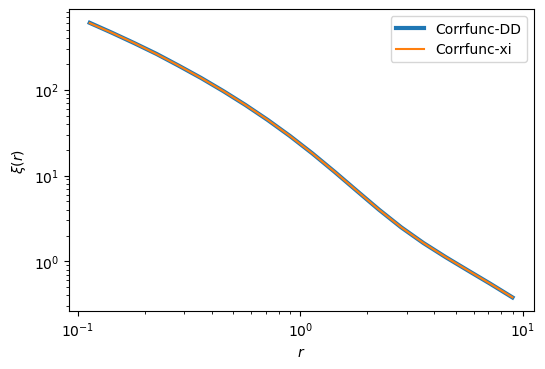

In [21]:
plt.figure(dpi = 100)
plt.plot(rx, cf, lw = 3, label = 'Corrfunc-DD')
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')

Now, we use Corrfunc to calculate the pairs, and we compute correlation function by ourselves.

Note: if we compute the correlation function by ourselves, we need to increase the number of random sample. And the function from xi does not use this

In [45]:
xx, yy, zz = ptpos[:,0], ptpos[:,1], ptpos[:,2] 

rand_N = len(ptpos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')

# DD
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins

DD_counts = DD(1, 48, bins, xx, yy, zz, periodic = False, verbose = True)

# DR
DR_counts = DD(0, 48, bins, xx, yy, zz,
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)

# RR
RR_counts = DD(1, 48, bins, rand_X, rand_Y, rand_Z,
               periodic = False, verbose = True)

Running with points in [xmin,xmax] = 0.000000,999.999939 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,999.999939 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,999.999939 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,99.  Time taken =  19.323 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    82 secs
ND1 =     23192798 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [999.999939,999.999939,999.999939]
ND2 =     46385596 [xmin,ymin,zmin] = [0.000000,0.000000,0.000000], [xmax,ymax,zmax] = [1000.000000,1000.000000,1000.000000]
Running with points in [xmin,xmax] = 0.000000,1000.000000 (non-periodic)
Running with points in [ymin,ymax] = 0.000000,1000.000000 (non-periodic)
Running with points in [zmin,zmax] = 0.000000,1000.000000 (non-periodic)
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 

23192798 46385596


Text(0, 0.5, '$\\xi(r)$')

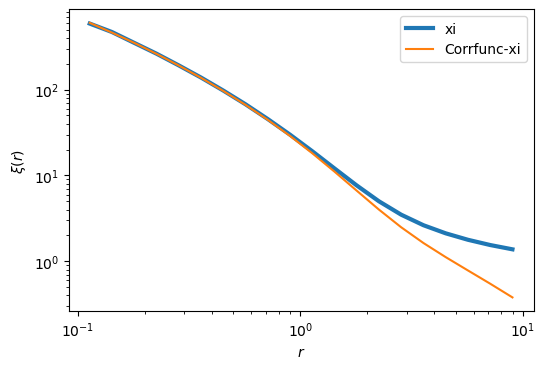

In [46]:
N = len(xx)
rand_N = len(rand_X)
print(N, rand_N)

DD_v = DD_counts['npairs'] / (N*(N-1)/2) 
DR_v = DR_counts['npairs'] / (N*rand_N) 
RR_v = RR_counts['npairs'] / (rand_N*(rand_N-1)/2)
xi_v = (DD_v - 2*DR_v + RR_v)/RR_v

rx = (bins[1:] + bins[:-1])/2 
plt.figure(dpi = 100)
plt.plot(rx, xi_v, lw = 3, label = 'xi')

plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')

#### From CAMB

Note CAMB usually used to compute power spectrum rather than correlation function. We need to integrate it by ourselves.

In [60]:
def wp_from_camb():
    import camb
    import numpy as np
    from mcfit import P2xi
    
    from scipy.interpolate import interp1d
    from scipy.integrate import quad

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
    pars.InitPower.set_params(ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=10.0)
    
    #note we need to consider non-linear effect
    pars.NonLinear = camb.model.NonLinear_both
    
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(
        minkh=1e-4, maxkh=100, npoints=2048
    )
    r_camb, xi_camb = P2xi(kh)(pk)
    
    return r_camb, xi_camb

In [61]:
r_camb, xi_camb = wp_from_camb()

/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


(0.1, 1000.0)

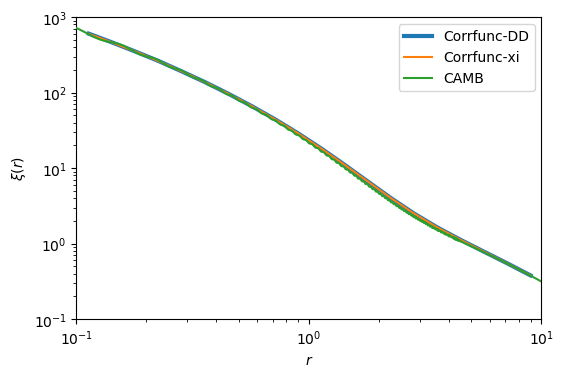

In [57]:
plt.figure(dpi = 100)
plt.plot(rx, cf, lw = 3, label = 'Corrfunc-DD')
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)
plt.plot(r_camb, xi_camb[0], label = 'CAMB', zorder = 100)


plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(1e-1, 1e1)
plt.ylim(1e-1, 1e3)

#### From Nbodykit

In [73]:
def Nbodykit_result(pos, mass, Lbox, Ngrid):
    from nbodykit.lab import ArrayCatalog, FFTPower, FFTCorr  
    cat = ArrayCatalog({'Position': pos,
                       'Mass': mass})  
    mesh = cat.to_mesh(
        BoxSize=Lbox,
        Nmesh=Ngrid,
        resampler='cic',  # 'ngp', 'cic', 'tsc'
        compensated=False,    
        interlaced=False,     
        weight='Mass',
        position='Position'
    )  
    
    corr = FFTCorr(mesh, mode='1d', rmin = 0.001, rmax = 10)  
    corr.run()  
    r_kit = corr.corr['r']  
    xi_kit = corr.corr['corr']  

    return r_kit, xi_kit

In [77]:
r_kit, xi_kit = Nbodykit_result(ptpos, np.ones(len(ptpos)), 1000, 1024)

(0.1, 1000.0)

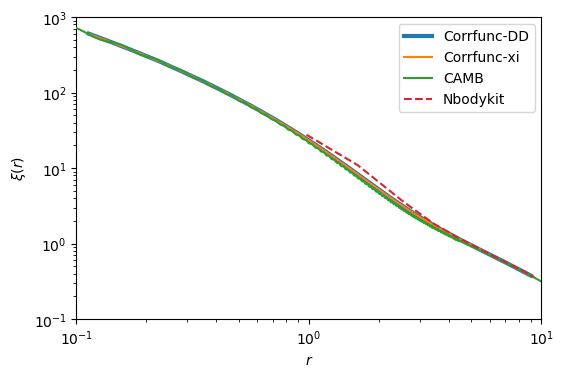

In [78]:
plt.figure(dpi = 100)
plt.plot(rx, cf, lw = 3, label = 'Corrfunc-DD')
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)
plt.plot(r_camb, xi_camb[0], label = 'CAMB', zorder = 100)
plt.plot(r_kit, xi_kit, ls = '--', label = 'Nbodykit', zorder = 200)


plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.xlim(1e-1, 1e1)
plt.ylim(1e-1, 1e3)

### w(p)

We will show the projected correlation function in the simulation box

#### From Corrfunc

In [79]:
from Corrfunc.theory.DDrppi import DDrppi
from Corrfunc.utils import convert_rp_pi_counts_to_wp
def sim_rppi_corrfunc_calculation(bins, x, y, z, 
                                  rand_x, rand_y, rand_z, 
                                  nthreads=None, pimax=40, boxsize=1000):

    if nthreads is None:
        nthreads = os.cpu_count()
    
    # DD
    DD_counts = DDrppi(
        autocorr=1, nthreads=nthreads, pimax=pimax, binfile=bins,
        X1=x, Y1=y, Z1=z,
        boxsize=boxsize,
        verbose = True
    )

    # DR
    DR_counts = DDrppi(
        autocorr=0, nthreads=nthreads, pimax=pimax, binfile=bins,
        X1=x, Y1=y, Z1=z,
        X2=rand_x, Y2=rand_y, Z2=rand_z,
        boxsize=boxsize, verbose = True
    )

    # RR
    RR_counts = DDrppi(
        autocorr=1, nthreads=nthreads, pimax=pimax, binfile=bins,
        X1=rand_x, Y1=rand_y, Z1=rand_z,
        boxsize=boxsize, verbose = True
    )

    N = len(x)
    rand_N = len(rand_x)
    nrpbins = len(bins) - 1

    cf = convert_rp_pi_counts_to_wp(
        N, N, rand_N, rand_N,
        DD_counts, DR_counts, DR_counts, RR_counts,
        nrpbins, pimax
    )
    return cf

In [80]:
#run
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins
cf_wp = sim_rppi_corrfunc_calculation(bins, xx, yy, zz, rand_X, rand_Y, rand_Z, nthreads = 32)
rx = (bins[1:] + bins[:-1])/2 

In [82]:
#here direcly using corrfunc to calculate

nthreads = 18
res = wp(boxsize=1000,
         pimax=40,
         nthreads=8,
         binfile=bins,
         X=xx, Y=yy, Z=zz,
         verbose = True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,25.  Time taken =   8.561 sec
Using AVX2 kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    76 secs


Text(0, 0.5, '$w_p$')

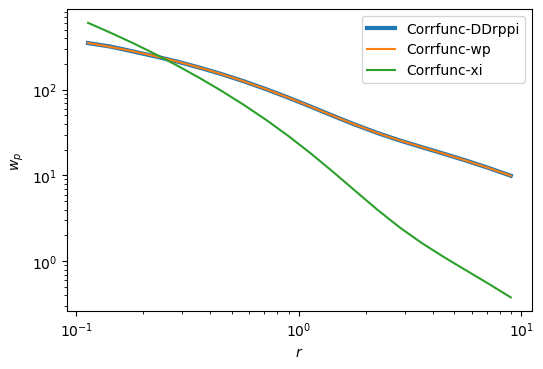

In [84]:
plt.figure(dpi = 100)
plt.plot(rx, cf_wp, lw = 3, label = 'Corrfunc-DDrppi')
plt.plot(rx, res['wp'], label = 'Corrfunc-wp', zorder = 100)
plt.plot(rx, results_xi['xi'], label = 'Corrfunc-xi', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$w_p$')

## Simulation-Halo

### $\xi$(r) without mass weight

In [5]:
spnum = '127'
filepath = '/home/qyli/work2025/densityfield'
dhalo = h5py.File(filepath + '/data/sample_fof_M1000_snapshot%s_halos.hdf5'%spnum, 'r')

halo_pos = dhalo['group_pos'][0,:,:]
halo_mass = dhalo['group_mass'][0,:]

idx_ = (halo_mass > 12)      
halo_pos = halo_pos[idx_]
halo_mass = halo_mass[idx_]

In [7]:
#generate a random catalog
boxsize = 1000
xx_halo = halo_pos[:,0]
yy_halo = halo_pos[:,1]
zz_halo = halo_pos[:,2]

rand_N = len(halo_pos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins

DD_counts = DD(1, 48, bins, xx_halo, yy_halo, zz_halo, periodic = False, verbose = True)
DR_counts = DD(0, 48, bins, xx_halo, yy_halo, zz_halo,
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)
RR_counts = DD(1, 48, bins, rand_X, rand_Y, rand_Z,
               periodic = False, verbose = True)

N = len(xx_halo)
cf = convert_3d_counts_to_cf(
    N, N, rand_N, rand_N,
    DD_counts, DR_counts,
    DR_counts, RR_counts
)

In [11]:
xx_halo = halo_pos[:,0]
yy_halo = halo_pos[:,1]
zz_halo = halo_pos[:,2]

nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins
results_xi_halo = xi(boxsize, 48, bins, xx_halo, yy_halo, zz_halo)

(0.1, 1000.0)

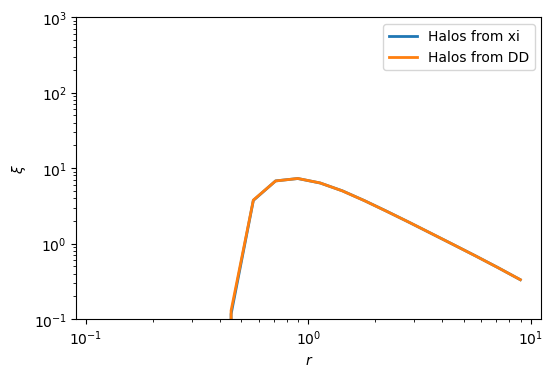

In [12]:
plt.figure(dpi = 100)
rx = (bins[1:] + bins[:-1]) / 2

plt.plot(rx, results_xi_halo['xi'], lw = 2, label = 'Halos from xi')
plt.plot(rx, cf, lw = 2, label = 'Halos from DD')
# plt.plot(rx, xi_v, lw = 2, label = 'Halos w weights (w/o Corrfunc)')
# plt.plot(rx, results_xi['xi'], label = 'DM', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi$')

plt.ylim(1e-1, 1e3)

###  $\xi$(r) without mass weight

In [16]:
#generate a random catalog
boxsize = 1000
xx_halo = halo_pos[:,0]
yy_halo = halo_pos[:,1]
zz_halo = halo_pos[:,2]

rand_N = len(halo_pos)*2
rand_X = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Y = np.random.uniform(0, boxsize, rand_N).astype('float32')
rand_Z = np.random.uniform(0, boxsize, rand_N).astype('float32')
nbins = 20
bins = np.logspace(-1, 1, nbins + 1) # note that +1 to nbins

DD_counts_w = DD(1, 48, bins, xx_halo, yy_halo, zz_halo, weights1 = 10**halo_mass, weight_type = 'pair_product', periodic = False, verbose = True)
DR_counts_w = DD(0, 48, bins, xx_halo, yy_halo, zz_halo, weights1 = 10**halo_mass, weight_type = 'pair_product',
               X2=rand_X, Y2=rand_Y, Z2=rand_Z, periodic = False, verbose = True)
RR_counts_w = DD(1, 48, bins, rand_X, rand_Y, rand_Z,
               periodic = False, verbose = True)

N = len(xx_halo)
cf_weight = convert_3d_counts_to_cf(
    N, N, rand_N, rand_N,
    DD_counts_w, DR_counts_w,
    DR_counts_w, RR_counts_w
)

(0.1, 1000.0)

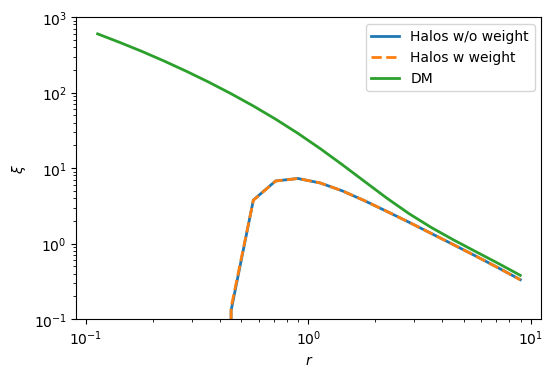

In [30]:
plt.figure(dpi = 100)
rx = (bins[1:] + bins[:-1]) / 2

plt.plot(rx, cf, lw = 2, label = 'Halos w/o weight')
plt.plot(rx, cf_weight, lw = 2, ls = '--', label = 'Halos w weight')

#=========================================================
# xi_DM = xi(1000, 36, bins, ptpos[:,0], ptpos[:,1], ptpos[:,2])
plt.plot(rx, xi_DM['xi'], lw = 2, ls = '-', label = 'DM')

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi$')

plt.ylim(1e-1, 1e3)

### $w_p$

In [33]:
wp_halo = wp(boxsize=1000,
         pimax=40,
         nthreads=36,
         binfile=bins,
         X=xx_halo, Y=yy_halo, Z=zz_halo,
         verbose = True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,25.  Time taken =   5.069 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 18.144 secs


In [36]:
wp_pt = wp(boxsize=1000,
         pimax=40,
         nthreads=36,
         binfile=bins,
         X=ptpos[:,0], Y=ptpos[:,1], Z=ptpos[:,2],
         verbose = True)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 100,100,25.  Time taken =  11.621 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =    75 secs


(1.0, 1000.0)

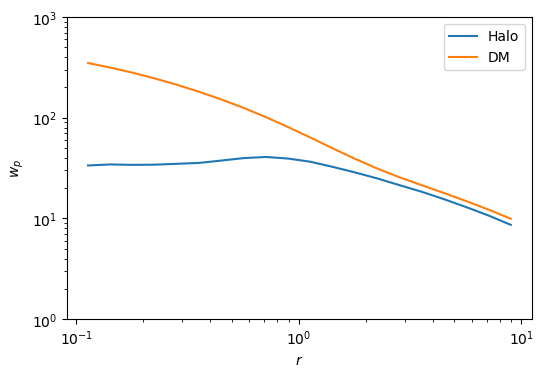

In [38]:
plt.figure(dpi = 100)
plt.plot(rx, wp_halo['wp'], label = 'Halo', zorder = 100)
plt.plot(rx, wp_pt['wp'], label = 'DM', zorder = 100)

plt.legend()
plt.loglog()
plt.xlabel(r'$r$')
plt.ylabel(r'$w_p$')

plt.ylim(1e0, 1e3)

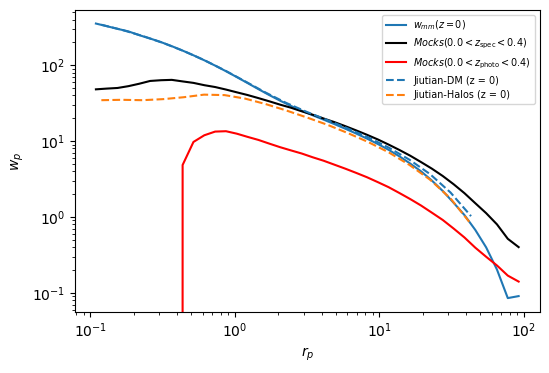

In [36]:
dgroup_zspec = np.loadtxt('/home/qyli/work2025/densityfield/corrfunc/data/corrf_originwp_9tianM_SpecNGC_mlim12_Ngrid350_sigma1.0_z0.4-0.6.txt')
dgroup_zphoto = np.loadtxt('/home/qyli/work2025/densityfield/corrfunc/data/corrf_originwp_9tianPhotoM_NGC_mlim12_Ngrid350_sigma1.0_z0.4-0.6.txt')

dsim127 = np.loadtxt('/home/qyli/work2025/densityfield/corrfunc/data/test/corrauto_wp_Jiutian_M1000_snapshot127_rd0.0001_shortrandN.txt')

plt.figure(dpi = 100)
xx = dsim127[:,0]; yy = dsim127[:,1]
plt.plot(xx, yy, c = 'C0', label = r'$w_{mm} (z = 0)$')

xx = dgroup_zspec[:,0]; yy = dgroup_zspec[:,1]
plt.plot(xx, yy, c = 'k', label = r'$Mocks (0.0 < z_{\rm spec} < 0.4)$')

xx = dgroup_zphoto[:,0]; yy = dgroup_zphoto[:,1]
plt.plot(xx, yy, c = 'r', label = r'$Mocks (0.0 < z_{\rm photo} < 0.4)$')

xx = (rp_bins[1:] + rp_bins[:-1])/2
plt.plot(xx, wp_rp, ls = '--', label = 'Jiutian-DM (z = 0)')
plt.plot(xx, wp_halo, ls = '--', label = 'Jiutian-Halos (z = 0)')

# dyang05 = np.array([
# [2.9052899958726304, 1.751619870410367],
# [3.8814052410168274, 1.8596112311015114],
# [5.169620289710067, 1.518358531317494],
# [6.909023822480367, 1.2030237580993512],
# [9.233746995547353, 0.8790496760259177],
# [12.253830773093839, 0.7451403887688981],
# [16.432504153113616, 0.49460043196544223],
# [21.812449258060447, 0.0755939524838003],
# [29.147587847687735, -0.07991360691144811],
# ])
# plt.plot(dyang05[:,0], 10**dyang05[:,1]*dyang05[:,0], ls = '-', label = 'Yang05(groups)')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('$r_p$')
plt.ylabel('$w_p$')
plt.legend(fontsize = 'x-small', loc = 1)

## r

(20, 2)
20
20
20
20
20
20


/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt
/home/qyli/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


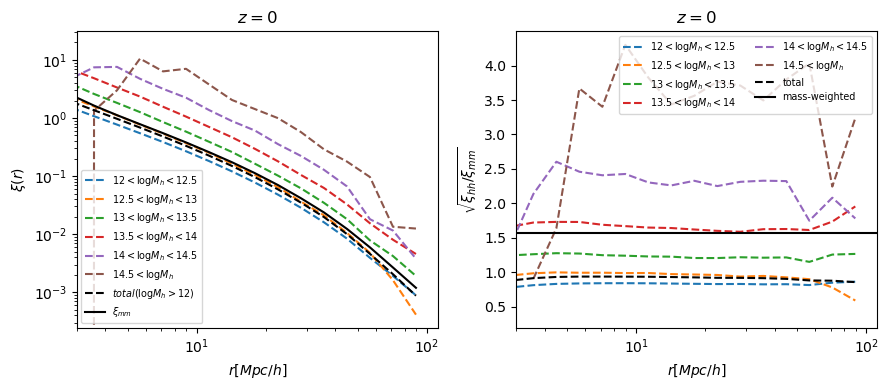

In [47]:
fsim = ['/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_mbin12_snapshot127.txt',
         '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_mbin12.5_snapshot127.txt',    '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_mbin13_snapshot127.txt',
         '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_mbin13.5_snapshot127.txt',
         '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_mbin14_snapshot127.txt',
         '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_mbin14.5_snapshot127.txt',
 ]

labs = [r'$12 < \log M_h < 12.5$', r'$12.5 < \log M_h < 13$',r'$13 < \log M_h < 13.5$',r'$13.5 < \log M_h < 14$',r'$14 < \log M_h < 14.5$',r'$14.5 < \log M_h$',]

plt.figure(figsize = (9, 4), dpi = 100)

plt.subplot(121)
for i in range(6):
    d = np.loadtxt(fsim[i])
    xx = d[:,0]; yy = d[:,1]
    plt.plot(xx, yy, '--', c = 'C%s'%i, label = labs[i])
    
filename = '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_halos_Mlim12_snapshot127.txt'
d = np.loadtxt(filename)
xtot = d[:,0]; ytot = d[:,1]
plt.plot(xtot, ytot, 'k--', label = r'$total (\log M_h > 12)$')
print(d.shape)

filename = '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_snapshot127_rd0.0001.txt'
d = np.loadtxt(filename)
xx = d[:,0]; yy = d[:,1]
plt.plot(xx, yy, 'k-', label = r'$\xi_{mm}$')

plt.legend(fontsize = 'x-small')
plt.loglog()
plt.xlabel(r'$r [Mpc/h]$')
plt.ylabel(r'$\xi(r)$')
plt.title(r'$z = 0$')
plt.xlim(3,)

#=============================================================
filename = '/home/qyli/work2025/densityfield/corrfunc/data/corrauto_Jiutian_M1000_snapshot127_rd0.0001.txt'
dp = np.loadtxt(filename)
xp = dp[:,0]; yp = dp[:,1]

plt.subplot(122)
for i in range(6):
    d = np.loadtxt(fsim[i])
    xx = d[:,0]; yy = d[:,1]
    print(len(xx))
    plt.plot(xx, (yy/yp)**0.5, '--', c = 'C%s'%i, label = labs[i])
    
plt.plot(xtot, (ytot/yp)**0.5, '--', c = 'k', label = 'total')

plt.axhline(1.568, color = 'k', ls = '-', label = 'mass-weighted')

plt.legend(loc = 'best', fontsize = 'x-small', ncol = 2)
plt.xscale('log')
plt.xlabel(r'$r [Mpc/h]$')
plt.ylabel(r'$\sqrt{\xi_{hh}/\xi_{mm}}$')
plt.title(r'$z = 0$')
plt.xlim(3,)

plt.tight_layout()


In [ ]:
    xi_interp = interp1d(r, xi, bounds_error=False, fill_value=0.0)

    def wp_rp(rp, pimax=40):
        integrand = lambda pi: xi_interp(np.sqrt(rp**2 + pi**2))
        return 2 * quad(integrand, 0, pimax)[0]

    rp = np.logspace(-1, 1.5, 20)
    wp = np.array([wp_rp(x) for x in rp])
    
    return rp,wp